In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
import pandas as pd

from gpr4im import pk_tools as pk
from gpr4im import fg_tools as fg

In [2]:
# for plotting:
%matplotlib inline

font = {"size": 16, "family": "STIXGeneral"}
axislabelfontsize = "x-large"
plt.rc("font", **font)
plt.rcParams["text.usetex"] = True

# Running GPR

In this notebook, we show how to run Gaussian Process Regression (GPR) as a foreground removal technique on single-dish HI IM simulations. For a more thorough explanation of how GPR works, please see `Understanding GPR.ipynb`.

## Loading data

First, we load all the raw data we need for the analysis:

- Foregrounds (with polarisation)
- HI cosmological signal + instrumental noise

And make sure the data is in $[Nx, Ny, Nz]$ format, where $Nz$ is the line of sight (frequency) direction. Our box has dimensions:
- Nx, Ny, Nz = 256, 256, 285
- Lx, Ly, Lz = 1000, 1000, 924.78 Mpc/$h$

The data is smoothed by a constant telescope beam, which is the largest beam given by the beam size at the highest redshift ($z=0.58$). The central redshift of the data is $z=0.39$.

We also load the frequency range of our data, `freqs`. The data goes from 899MHz to 1183MHz in 1MHz increments.

In [3]:
data = pd.read_pickle('../Data/data.pkl')
FGwpol_HI_noise_data = data.beam.FGwpol_HI_noise
HI_noise_data = data.beam.HI_noise
freqs = data.freqs

Now we run PCA foreground cleaning in order to compare these results to GPR:

In [4]:
pca_res_7 = fg.PCAclean(FGwpol_HI_noise_data, N_FG=7)[0]

## Running GPR

We start by choosing which kernels we will use for each component in our data:

In [5]:
# kernel for the smooth foreground:
kern_fg_smooth = GPy.kern.RBF(1)
# kernel for the polarised foreground:
kern_fg_pol = GPy.kern.RBF(1)
# add foreground kernels together:
kern_fg = kern_fg_smooth + kern_fg_pol
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)

We want to set priors for the kernels, to make sure the foreground kernels aren't fitting to the HI data and the HI kernel isn't fitting to the foregrounds.

In [6]:
# setting priors for the smooth foreground kernel:
kern_fg.rbf.variance.constrain_bounded(1000,100000000)
kern_fg.rbf.lengthscale.constrain_bounded(200,10000)
# setting priors for the polarised foreground kernel:
kern_fg.rbf_1.variance.constrain_bounded(0.0001,10)
kern_fg.rbf_1.lengthscale.constrain_bounded(15,500)
# setting priors for the HI kernel:
kern_21.variance.constrain_bounded(0.000001,0.5)
kern_21.lengthscale.constrain_bounded(0.01,15)

reconstraining parameters sum.rbf.variance
reconstraining parameters sum.rbf.lengthscale
reconstraining parameters sum.rbf_1.variance
reconstraining parameters sum.rbf_1.lengthscale
reconstraining parameters Exponential.variance
reconstraining parameters Exponential.lengthscale


We now define the total kernel function for our data, which is the foreground kernel + the HI kernel:

In [7]:
kern = kern_fg + kern_21

To run GPR, we will need to make a few choices regarding our data. We simplify these choices in our code by assigning specific parameters that control each of them. The parameters you must set for running GPR are:

- `Input`: data cube to be cleaned, in $[Nx,Ny,Nz]$ format where $Nz$ is the frequency direction
- `num_restarts`: how many times to optimise the GPR regression model by restarting the GPR fit
- `NprePCA`: set to 0 if no pre-PCA is desired, otherwise this number is the $N_\text{FG}$ number of components used in a pre-PCA clean of the data
- `noise_data`: input here your noise map in $[Nx,Ny,Nz]$ if you have a reasonable estimate from your data, otherwise set to None and use GPR to try to fit your noise
- `zero_noise`: if True, the noise in your GPR model will be set to zero and fixed. Otherwise it will try to fit to noise in your data, in either the heteroscedastic or non-heteroscedastic case. Set to zero if you want to fit your noise with a separate kernel instead, otherwise you will fit to noise twice
- `heteroscedastic`: if True, runs Heteroscedastic regression model (where the noise variance changes with frequency) (Note: you cannot have noise=False and heteroscedastic=True at the same time, to set noise to zero set heteroscedastic=False too). If False, the noise variance will be assumed to be constant with frequency.
- `invert`: if True, inverts data in the frequency direction

In [8]:
Input = FGwpol_HI_noise_data
num_restarts = 15
NprePCA = 0
noise_data = None
zero_noise = True
heteroscedastic = False
invert = False

Now that we've decided on a kernel and noise model, we run the GPR foreground removal function, which yields the following outputs:

- `gpr_result.res`: residual map of HI and noise, after GPR foreground subtraction;
- `gpr_result.fgfit`: GPR's prediction for what our foregrounds look like, i.e. what we subtract from our original data to get `res`;
- `gpr_result.fgcov`: error covariance of the foreground estimate, i.e. how uncertain the estimate of the foreground is;
- `gpr_result.model`: summary of what the best fit hyperparameters were found for the kernels, and what the objective function is.

In [9]:
gpr_result = fg.GPRclean(Input, freqs, kern_fg, kern_21, NprePCA=NprePCA,
                                          noise_data=noise_data, heteroscedastic=heteroscedastic, 
                                          zero_noise=zero_noise, invert=invert)

 /opt/anaconda3/envs/testgpr2/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -46274836.77963373
Optimization restart 2/10, f = -46274836.74704962
Optimization restart 3/10, f = -46223444.69981388
Optimization restart 4/10, f = -46274836.38757089
Optimization restart 5/10, f = -45836978.38791156
Optimization restart 6/10, f = -46274837.00816016
Optimization restart 7/10, f = -46223541.41763156
Optimization restart 8/10, f = -46274836.951773494
Optimization restart 9/10, f = -45836976.716470465
Optimization restart 10/10, f = -46223423.56806296


We can print the optimised model to see things such as the objective function (which we want to be as small as possible), and also the best fit hyperparameters for the kernels. The `Objective` parameter describes how good of a fit our model is, and we want this to be as small as possible (i.e., a large negative number).

In [10]:
gpr_result.model

GP_regression.,value,constraints,priors
sum.rbf.variance,67165.12693160221,"1000.0,100000000.0",
sum.rbf.lengthscale,475.2828111750747,"200.0,10000.0",
sum.rbf_1.variance,0.49926988018272506,"0.0001,10.0",
sum.rbf_1.lengthscale,58.415570289540476,"15.0,500.0",
sum.Exponential.variance,0.0012143448901228173,"1e-06,0.5",
sum.Exponential.lengthscale,6.725502856136214,"0.01,15.0",
Gaussian_noise.variance,0.0,+ve fixed,


## Plot power spectrum

In [11]:
# Grid dimension of data cube:
lx,ly,lz = 1000,1000, 924.78 #Mpc/h
nx,ny,nz = 256, 256, 285
# weighting and window function:
w = W = np.ones((nx,ny,nz))
# minimum and maximum k in each direction:
kmin = 2*np.pi/pow(lx*ly*lz, 1/3)
kmax= 1
# set width of k bins to be 2*kmin
dk = 2*kmin
# number of k bins:
nkbin = int((kmax-kmin)/dk)
# setting array of k bin edges:
kbins = np.arange(kmin,kmax,dk)
# setting array of k bin centers"
k = np.linspace(kmin+0.5*dk,kmax-0.5*dk,nkbin)

Calculate bias correction to the 3D power spectrum only:

In [12]:
n_samples = 10
pk_corr = pk.get_biascorr(gpr_result.fgcov, Input, n_samples, lx, ly, lz, kbins, kbins, w, W)[0]

Calculate spherically averaged power spectra:

In [13]:
pk_HI = pk.getpk(HI_noise_data,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]
pk_GPR = pk.getpk(gpr_result.res,w,W,nx,ny,nz,lx,ly,lz,kbins)[0] + pk_corr
pk_PCA7 = pk.getpk(pca_res_7,w,W,nx,ny,nz,lx,ly,lz,kbins)[0]

Text(0.5, 0, '$k$ [$h$/Mpc]')

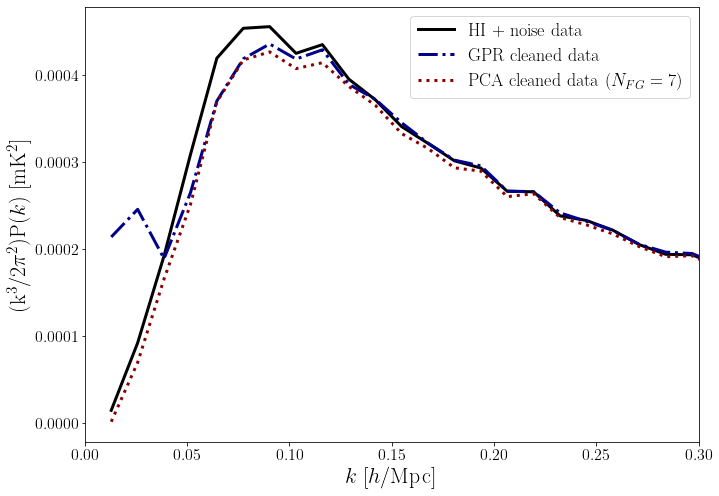

In [14]:
plt.figure(figsize=(11,8))

plt.plot(k, (k*k*k*pk_HI)/(2*np.pi*np.pi), ls='solid', lw=3, c='k', label = r'HI + noise data')
plt.plot(k, (k*k*k*pk_GPR)/(2*np.pi*np.pi), ls='dashdot', lw=3, c='darkblue', label = r'GPR cleaned data')
plt.plot(k, (k*k*k*pk_PCA7)/(2*np.pi*np.pi), ls='dotted', lw=3, c='darkred', label = r'PCA cleaned data ($N_{FG}=7$)')

plt.legend(fontsize=18)
plt.xlim(0,0.3)
plt.ylabel('(k$^3$/2$\pi^2$)P($k$) [mK$^2$]', fontsize=22)
plt.xlabel('$k$ [$h$/Mpc]', fontsize=22)